## Examining the Relationship Between Economic Instability of Several Countries and BitCoin Market Capitalization

### Authors: Achal Srinivasan and Corrin Fosmire

### Section 1: Setting up Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
import time
import datetime as dt
%matplotlib inline
plt.rcParams['figure.figsize'] = (20,10)

/home/infrared/anaconda3/lib/python3.6/site-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.24.1) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
#using IMF API, acquire information for a particular country
def generate_data(country_abbr="US", metric="PXP_IX", resolution="M", start=2009, end=2017):
    data = requests.get("http://dataservices.imf.org/REST/SDMX_JSON.svc/CompactData/IFS/"+resolution+"."+country_abbr+"."+metric+".?startPeriod="+str(start)+"&endPeriod="+str(end)).json()
    df = pd.DataFrame(data['CompactData']['DataSet']['Series']['Obs'])
    df = df.rename(index=str, columns={"@OBS_VALUE" : country_abbr+"."+metric, "@TIME_PERIOD" : "date"})
    return df

In [3]:
#loading economic health data for certain countries

countries = ["US", "KR", "JP", "RU"]
#United States, South, Korea, Japan, Russia

metrics = ["LE_IX", "PCPI_IX", "ENDE_XDC_USD_RATE"]
#consumer price index (should indicate inflation), exchange rate (in domestic currency), employment index

generate_data(country_abbr="KR",metric="LE_IX").head()

,KR.LE_IX,date
0,95.9151326814698,2009-01
1,95.4095737874995,2009-02
2,96.9304114479616,2009-03
3,98.6559692531425,2009-04
4,99.4640312877847,2009-05


In [4]:
def make_dataset(countries, metrics):
    #make first table, so then we can do joins on the rest
    empty = True
    full_data = None
    
    for country in countries:
        for metric in metrics:
            if empty:
                full_data = generate_data(country_abbr=country, metric=metric)
                empty = False
            else:
                metric_data = generate_data(country_abbr=country, metric=metric)
                full_data = full_data.merge(metric_data, on="date")
        time.sleep(5) #avoid throttling
                

    return full_data

In [5]:
financial_data = make_dataset(countries, metrics)

In [6]:
#deleting status variables we don't really care about
financial_data = financial_data[list(filter(lambda a: not a[0] == "@", list(financial_data.columns.values)))]

In [7]:
financial_data["date"] = financial_data["date"]+"-01"

In [8]:
#loading bitcoin data
btc_data = pd.read_csv("btc.csv")
btc_data = btc_data[btc_data["marketcap(USD)"] != np.nan]

#selecting columns of interest
mc_date = btc_data[["date","marketcap(USD)"]]

#converting to date time format
mc_date['date'] = pd.to_datetime(mc_date['date'])
mc_date = mc_date.dropna()
mc_date['date'] = mc_date['date'].dt.strftime(date_format="%Y-%m-%d")
mc_date.head()

/home/infrared/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,date,marketcap(USD)
1570,2013-04-28,1.500656e+09
1571,2013-04-29,1.491703e+09
1572,2013-04-30,1.598310e+09
1573,2013-05-01,1.543334e+09
1574,2013-05-02,1.292577e+09


In [9]:
combined = mc_date.merge(financial_data, on="date", how="left")
combined['date'] = pd.to_datetime(combined['date'])
combined = combined[combined['date'] < pd.to_datetime('2016-06-01')]

#convert data to numbers for interpolation & inference
for country in countries:
    for metric in metrics:
        combined[country+"."+metric] = pd.to_numeric(combined[country+"."+metric])

combined = combined.interpolate(method='linear').dropna()
combined.head()

,date,marketcap(USD),US.LE_IX,US.PCPI_IX,US.ENDE_XDC_USD_RATE,KR.LE_IX,KR.PCPI_IX,KR.ENDE_XDC_USD_RATE,JP.LE_IX,JP.PCPI_IX,JP.ENDE_XDC_USD_RATE,RU.LE_IX,RU.PCPI_IX,RU.ENDE_XDC_USD_RATE
3,2013-05-01,1.543334e+09,103.860155,106.828307,1.0,106.564325,107.468047,1129.700000,100.886501,99.7669,101.030000,102.734328,120.884098,31.589300
4,2013-05-02,1.292577e+09,103.869643,106.836577,1.0,106.574405,107.463831,1130.096774,100.883428,99.7669,100.936774,102.720462,120.900475,31.625419
5,2013-05-03,1.180430e+09,103.879130,106.844847,1.0,106.584486,107.459615,1130.493548,100.880355,99.7669,100.843548,102.706596,120.916853,31.661539
6,2013-05-04,1.090276e+09,103.888618,106.853116,1.0,106.594566,107.455399,1130.890323,100.877282,99.7669,100.750323,102.692730,120.933230,31.697658
7,2013-05-05,1.255228e+09,103.898105,106.861386,1.0,106.604646,107.451183,1131.287097,100.874209,99.7669,100.657097,102.678864,120.949608,31.733777


#### We interpolate economic data between months to obtain an adequate sample size for our data and to resolve the difference in observation frequency between the market cap and the economic data. It seems reasonable to assume that economic data is not extremely volatile within a month, so we linearly interpolate the data points to produce reasonable estimates for every day, instead of every month, of the year. This makes training and testing much more effective.

In [10]:
combined.tail()

,date,marketcap(USD),US.LE_IX,US.PCPI_IX,US.ENDE_XDC_USD_RATE,KR.LE_IX,KR.PCPI_IX,KR.ENDE_XDC_USD_RATE,JP.LE_IX,JP.PCPI_IX,JP.ENDE_XDC_USD_RATE,RU.LE_IX,RU.PCPI_IX,RU.ENDE_XDC_USD_RATE
1125,2016-05-27,7.071638e+09,109.010305,110.168741,1.0,110.735706,110.717865,1191.7,102.744185,103.600104,111.09,103.450746,161.571897,66.0825
1126,2016-05-28,7.377352e+09,109.010305,110.168741,1.0,110.735706,110.717865,1191.7,102.744185,103.600104,111.09,103.450746,161.571897,66.0825
1127,2016-05-29,8.228550e+09,109.010305,110.168741,1.0,110.735706,110.717865,1191.7,102.744185,103.600104,111.09,103.450746,161.571897,66.0825
1128,2016-05-30,8.245898e+09,109.010305,110.168741,1.0,110.735706,110.717865,1191.7,102.744185,103.600104,111.09,103.450746,161.571897,66.0825
1129,2016-05-31,8.336733e+09,109.010305,110.168741,1.0,110.735706,110.717865,1191.7,102.744185,103.600104,111.09,103.450746,161.571897,66.0825


### Section 2: Exploratory Data Analysis

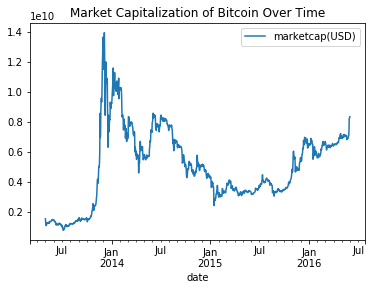

In [11]:
combined.plot(x='date',y='marketcap(USD)', title="Market Capitalization of Bitcoin Over Time")

#### We note that the market cap of BitCoin skyrocketed at the end of 2013, then gradually declined until 2015, where it rebounded again.

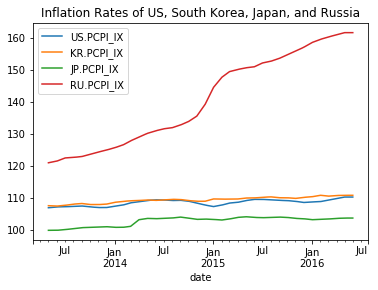

In [12]:
ax = combined.plot(x='date',y='US.PCPI_IX')
combined.plot(x='date',y='KR.PCPI_IX', ax=ax)
combined.plot(x='date',y='JP.PCPI_IX', ax=ax)
combined.plot(x='date',y='RU.PCPI_IX', ax=ax, title="Inflation Rates of US, South Korea, Japan, and Russia")

#### Clearly, Venezuela's inflation rate is far, far greater than the other countries, and has been increasing more and more quickly with time.

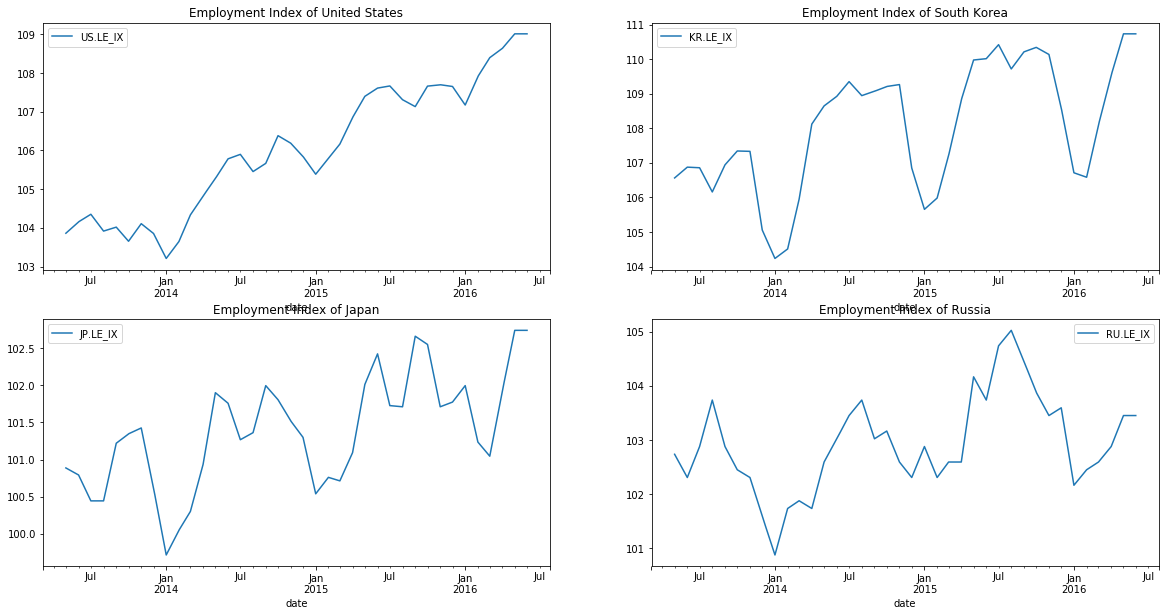

In [13]:
plt.rcParams['figure.figsize'] = (20,10)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)

combined.plot(x='date',y='US.LE_IX', ax=ax1, title="Employment Index of United States")
combined.plot(x='date',y='KR.LE_IX', ax=ax2, title="Employment Index of South Korea")
combined.plot(x='date',y='JP.LE_IX', ax=ax3, title="Employment Index of Japan")
combined.plot(x='date',y='RU.LE_IX', ax=ax4, title="Employment Index of Russia")

#### All four countries had notably low  employment indices in January 2014. South Korea and the US seem to have a high degree of cyclical unemployment, and the United States, Japan and South Korea all have an upward trend. Russia is volatile but the employment index is not consistently increasing.

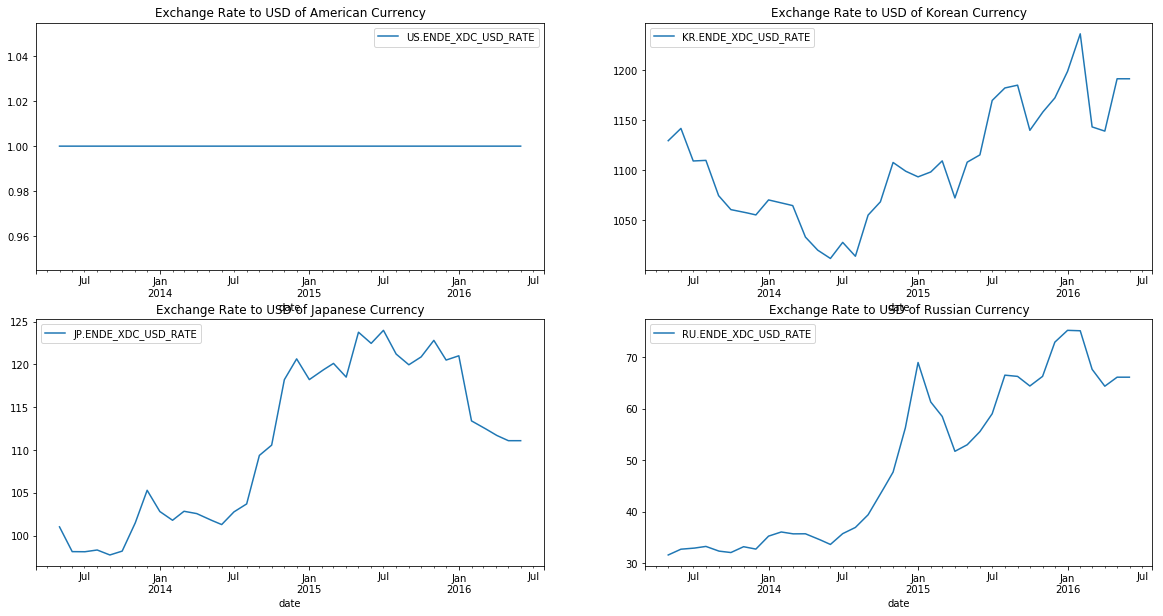

In [14]:
plt.rcParams['figure.figsize'] = (20,10)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)

combined.plot(x='date',y='US.ENDE_XDC_USD_RATE', ax=ax1, title="Exchange Rate to USD of American Currency")
combined.plot(x='date',y='KR.ENDE_XDC_USD_RATE', ax=ax2, title="Exchange Rate to USD of Korean Currency")
combined.plot(x='date',y='JP.ENDE_XDC_USD_RATE', ax=ax3, title="Exchange Rate to USD of Japanese Currency")
combined.plot(x='date',y='RU.ENDE_XDC_USD_RATE', ax=ax4, title="Exchange Rate to USD of Russian Currency")

#### Clearly, the exchange rate in USD of USD is 1, which explains the line of the American currency. All three other currencies have been devalued relative to the USD steadily from 2013 to 2016, although the Japanese currency has become relatively more valuable after January 2016.

### Section 3: Modeling

#### We will build models with and without exogenous regressors to predict BitCoin market cap, using the Facebook Prophet models.

In [15]:
import fbprophet

In [16]:
#measures of interest: these seem to experimentally give the best results

countries = ["US", "KR", "JP"]#, "RU"]
#United States, South, Korea, Japan, Russia

metrics = ["LE_IX", "PCPI_IX"]#, "ENDE_XDC_USD_RATE"]
#consumer price index (should indicate inflation), exchange rate (in domestic currency), employment index

In [17]:
#test/train split
cryptoecon_train = combined[combined['date'] < pd.to_datetime('2016-01-01')]
cryptoecon_test = combined[combined['date'] >= pd.to_datetime('2016-01-01')]

#### We will be predicting on the first 5 months of 2016 based on data from 2013 to the end of 2015.

In [18]:
#prophet dataframe preparation
prophet_df = pd.DataFrame(cryptoecon_train)
prophet_df['ds'] = prophet_df['date']
prophet_df['y'] = prophet_df['marketcap(USD)']

prophet_test = pd.DataFrame(cryptoecon_test)
prophet_test['ds'] = prophet_test['date']
prophet_test['y'] = prophet_test['marketcap(USD)']

In [19]:
#creating a model with no exogenous variables
no_exo_m = fbprophet.Prophet()#yearly_seasonality=False)
no_exo_m.fit(prophet_df)

#creating a model with all exogenous variables
all_exo_m = fbprophet.Prophet()#yearly_seasonality=False)

for country in countries:
    for metric in metrics:
        all_exo_m.add_regressor(country+"."+metric)
        
all_exo_m.fit(prophet_df)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


#### We are producing two Prophet models: one containing exogenous variables and one not containing exogenous variables. We would like to see that the model containing economic data as a regressor performs better than the one without.

In [20]:
no_exo_preds = no_exo_m.predict(prophet_test)
all_exo_preds = all_exo_m.predict(prophet_test)

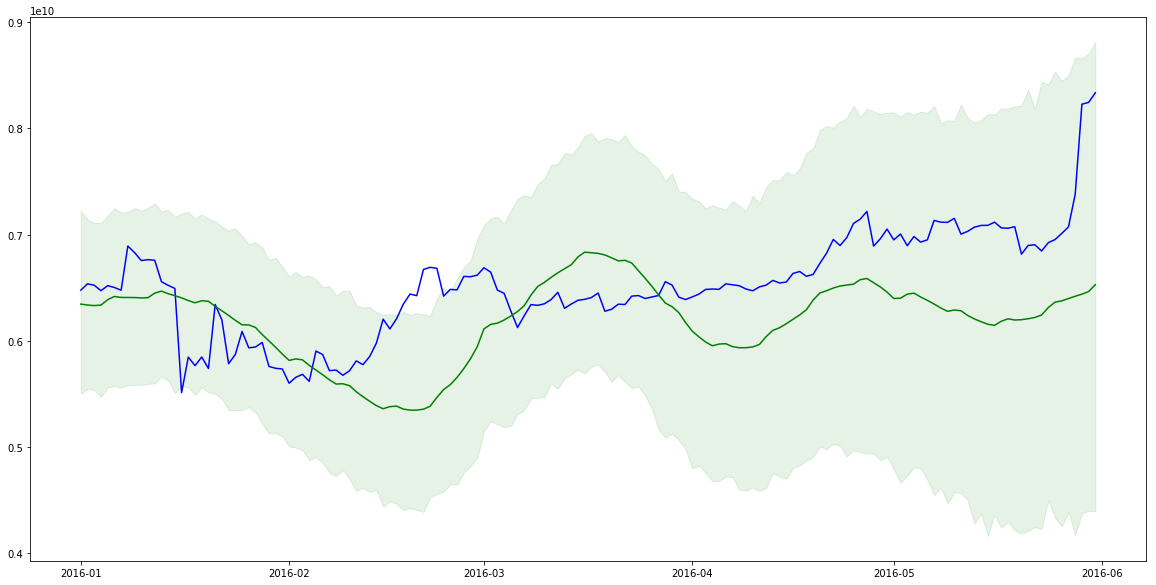

In [21]:
plt.plot(prophet_test['ds'].values, prophet_test['marketcap(USD)'].values, c="b")

plt.plot(prophet_test['ds'].values, all_exo_preds['yhat'].values, c="g")
plt.fill_between(prophet_test['ds'].values, all_exo_preds['yhat_lower'].values, all_exo_preds['yhat_upper'].values,alpha=0.1, color="g")

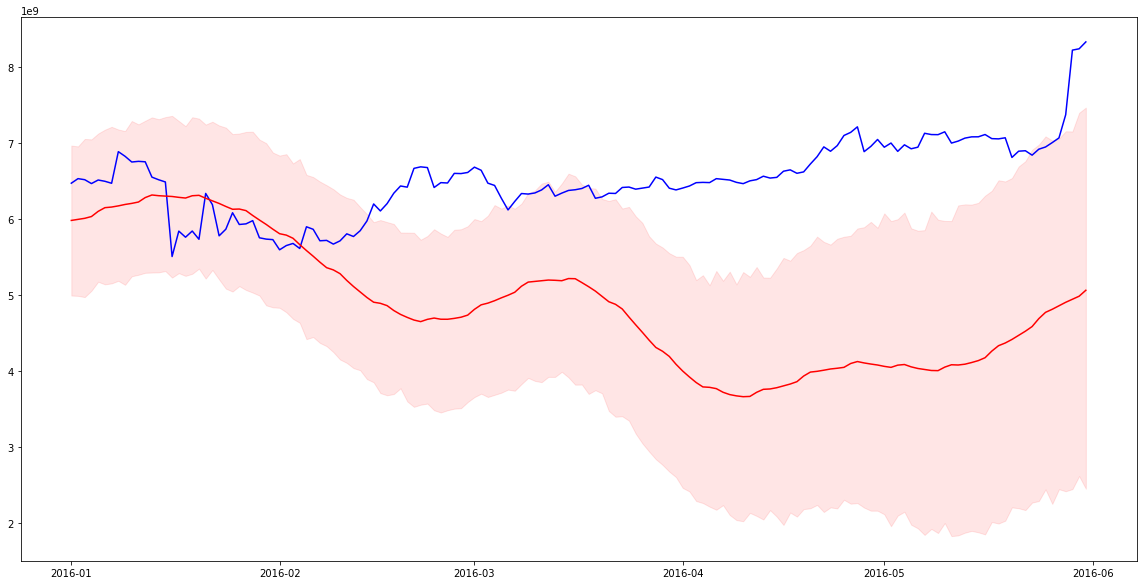

In [22]:
plt.plot(prophet_test['ds'].values, prophet_test['marketcap(USD)'].values, c="b")

plt.plot(prophet_test['ds'].values, no_exo_preds['yhat'].values, c="r")
plt.fill_between(prophet_test['ds'].values, no_exo_preds['yhat_lower'].values, no_exo_preds['yhat_upper'].values,alpha=0.1, color="r")

#### Clearly, the model with exogenous regressors is often much closer to the actual BitCoin market capitalization. Additionally, almost every point in the first six months of forecasting is in the prediction interval for the model with exogenous regressors, but roughly half the time the true value falls outside the prediction interval for the model with no exogenous regressors.

In [23]:
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
print("RMSE of no Exogenous Variables Model: \t" + str(sqrt(mean_squared_error(prophet_test['marketcap(USD)'].values, no_exo_preds['yhat'].values))))
print("RMSE of all Exogenous Variables Model: \t" + str(sqrt(mean_squared_error(prophet_test['marketcap(USD)'].values, all_exo_preds['yhat'].values))))

print(sqrt(mean_squared_error(prophet_test['marketcap(USD)'].values, no_exo_preds['yhat'].values)) / np.std(prophet_test['marketcap(USD)'].values))
print(sqrt(mean_squared_error(prophet_test['marketcap(USD)'].values, all_exo_preds['yhat'].values)) / np.std(prophet_test['marketcap(USD)'].values))

RMSE of no Exogenous Variables Model: 	2004137573.1770084
RMSE of all Exogenous Variables Model: 	594966108.1281198
4.085163316144708
1.2127579223124085


#### While the RMSE of the predictions looks high, this is mostly because of the scale of the market capitalization. In fact, our model with exogenous regressors predicts a model within a few standard deviations of the true value most of the time.

### Section 4: Data Visualization

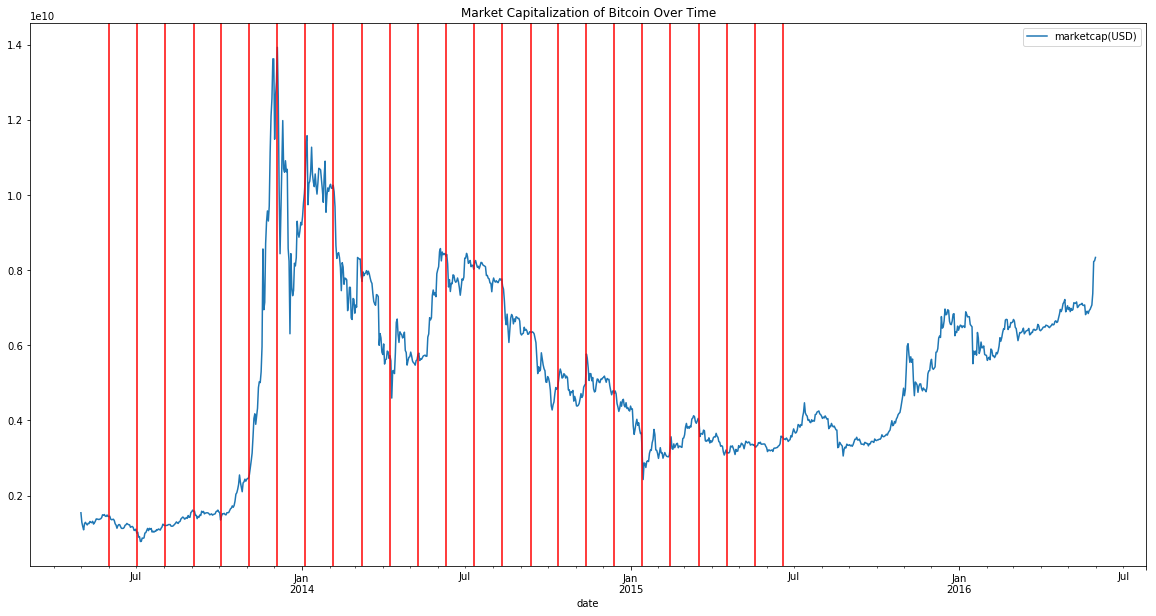

In [24]:
ax = combined.plot(x='date',y='marketcap(USD)', title="Market Capitalization of Bitcoin Over Time")

for chgpt in all_exo_m.changepoints:
    plt.axvline(x=chgpt, c='r')

#### The data is partitioned into several parts by the Prophet algorithm, which in this case appear to be mostly evenly spaced intervals.

''

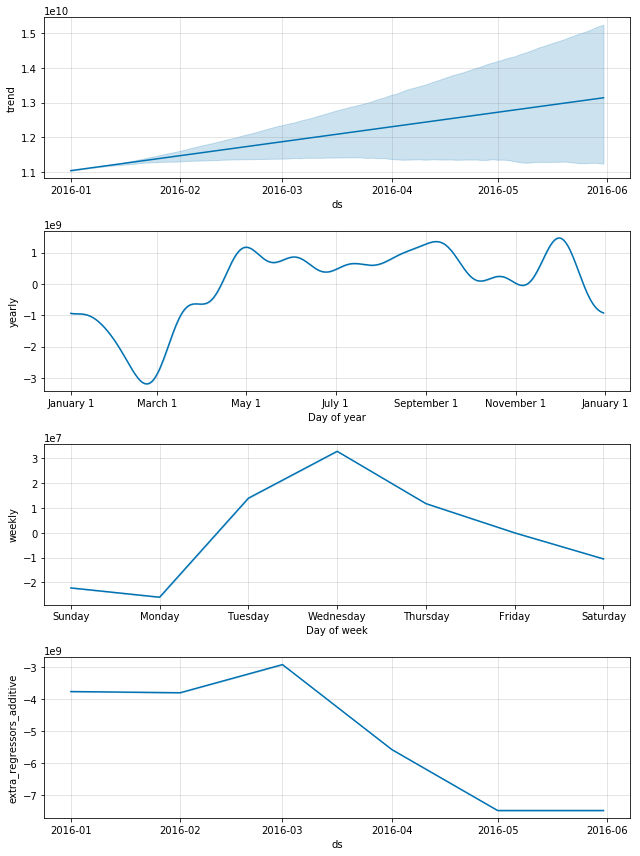

In [25]:
all_exo_m.plot_components(all_exo_preds)
""

#### There seems to be a fair bit of yearly and weekly seasonality in the BitCoin market capitalization, somewhat surprisingly. Also interestingly, the role of the exogenous regressors seems to fall noticeably between March and May of 2016.

In [26]:
def plot_forecast(actual, pred, yhat_lower, yhat_upper, title='Actual vs Forecast', 
                  xlabel='Date', ylabel='BitCoin Market Capitalization', 
                  grid=True, figsize=(15, 10)):
    plt.figure(figsize=figsize)
    plt.plot(actual, label='Actual')
    plt.plot(pred, label='Predicted', c='r')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc=0)
    plt.grid(True)
    
combined['y'] = combined['marketcap(USD)']
combined['ds'] = combined['date']
    
full_preds = all_exo_m.predict(combined)

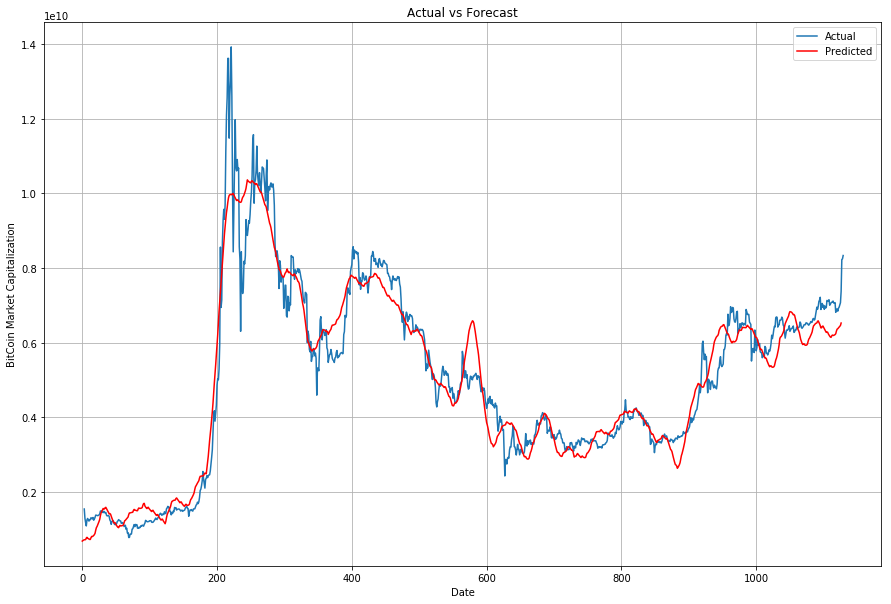

In [27]:
plot_forecast(combined['y'], full_preds['yhat'], full_preds['yhat_lower'], full_preds['yhat_upper'])

#### We can see that the Prophet model fairly accurately predicts the BitCoin market capitalization for the entire 3-year duration of the data set, although it is less sensitive to sudden jumps.